## Importing required libraries for the project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from statistics import mean
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer, SimpleImputer
from xgboost import XGBClassifier
from sklearn import metrics
warnings.filterwarnings('ignore')

### Importing the data set

In [2]:
ls

 Volume in drive C has no label.
 Volume Serial Number is EEA7-55FE

 Directory of C:\Users\acer\Desktop\python 15th december\Project

10-06-2024  20:16    <DIR>          .
15-05-2024  09:21    <DIR>          ..
10-06-2024  20:16    <DIR>          .ipynb_checkpoints
10-06-2024  20:16            54,709 APS_Sensor_Model.ipynb
18-05-2024  22:12    <DIR>          Domain Specific Projects
06-06-2024  17:20            84,530 EDA.ipynb
22-05-2024  19:39        26,974,483 sensor.csv
               3 File(s)     27,113,722 bytes
               4 Dir(s)  123,470,737,408 bytes free


In [3]:
sensor = pd.read_csv('sensor.csv', na_values= 'na')

In [4]:
sensor.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


In [5]:
sensor.shape

(36188, 171)

### Column Class is the target variable as it is classified into pos: positive, neg: negative
### lets check how the data is distributed

In [6]:
sensor['class'].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

### Here the data is imbalanced as it is more tilted towards negative redings. So model might not give accurate results, in this case we shall use any resampling techniques.

### Before resampling we shall check for null values and clean the data

In [7]:
sensor.isnull().sum()[0:20]

class         0
aa_000        0
ab_000    27896
ac_000     2141
ad_000     9200
ae_000     1587
af_000     1587
ag_000      379
ag_001      379
ag_002      379
ag_003      379
ag_004      379
ag_005      379
ag_006      379
ag_007      379
ag_008      379
ag_009      379
ah_000      382
ai_000      375
aj_000      375
dtype: int64

### There are missing values in many columns and the missing percentage is also higher in some columns. So lets remove the columns which has more than 30%  of missing data.

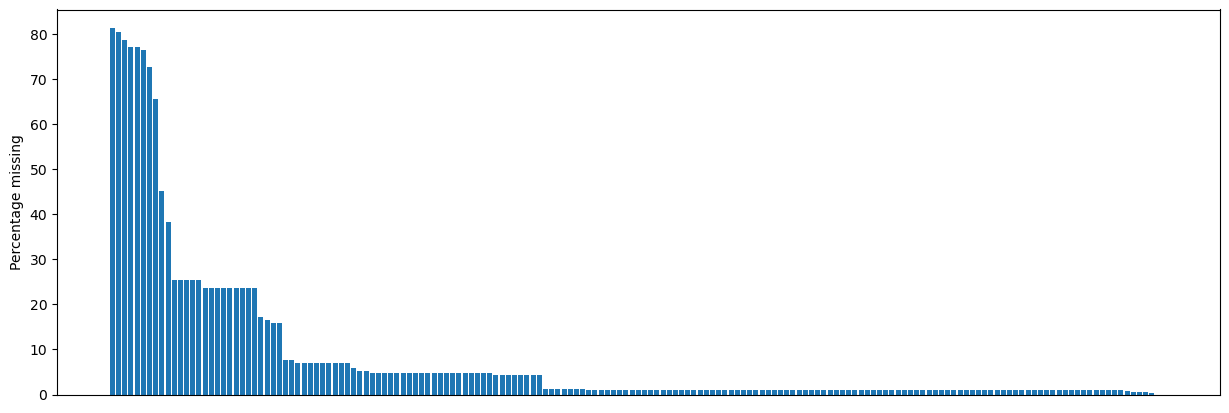

In [8]:
fig, ax = plt.subplots(figsize = (15,5))

missing = sensor.isna().sum().div(sensor.shape[0]).mul(100).to_frame().sort_values(by= 0, ascending = False)
ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

### some coulmns have more than 30% of missing data, lets remove those columns

In [9]:
dropcols = missing[missing[0]>30]
sensor.drop(list(dropcols.index), axis = 1, inplace = True)
sensor.shape

(36188, 161)

### Now lets split the data

In [10]:
x = sensor.drop('class', axis = 1)
y = sensor['class']

### Encoding the target variable that is y

In [11]:
y = y.replace({'pos':1, 'neg':0})

In [12]:
robust_scaler = RobustScaler()
x1 = robust_scaler.fit_transform(x)

### Now lets check for the best nearest neighbor using knn imputer to fill the null values 

In [13]:
result = []
imputer = KNNImputer(n_neighbors = 4)
strategies = [str(i) for i in [1,2,3,4]]
for s in strategies:
    pipeline = Pipeline(steps= [('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, x1, y, scoring='accuracy', cv = 2, n_jobs= -1)
    result.append(scores)
    print(f'n_neighbors {s} || accuracy {mean(scores)}')

n_neighbors 1 || accuracy 0.6957278655908036
n_neighbors 2 || accuracy 0.7327290814634686
n_neighbors 3 || accuracy 0.7504697689841937
n_neighbors 4 || accuracy 0.719934785011606


### as we can see the 3rd has better accuracy among these 4, so lets use that

In [14]:
knn_pipeline = Pipeline(steps= [
    ('imputer', KNNImputer(n_neighbors=3)),
    ('scaler', RobustScaler())
])

In [15]:
x_knn = knn_pipeline.fit_transform(x)

### now we will resample the data using minority strategy

In [16]:
from imblearn.combine import SMOTETomek

In [17]:
smt = SMOTETomek(random_state=101, sampling_strategy='minority', n_jobs=1)
x_res, y_res = smt.fit_resample(x_knn, y)

### Lets take some models to check which give the better result

In [18]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XG Boost': XGBClassifier()
}

In [19]:
def total_cost(y_true, y_pred):

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost


def evaluate_clf(true, predicted):

    acc = accuracy_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)

    return acc, f1, precision, recall, roc_auc


def evalute_model(X, y, models):

    # split of the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=101)

    cost_list = []
    model_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        # train the model
        model.fit(X_train, y_train)

        # make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # training set performance
        model_train_acc, model_train_f1, model_train_pre, model_train_recall, model_train_auc = evaluate_clf(y_train, y_train_pred)

        train_cost = total_cost(y_train, y_train_pred)

        # test set performance
        model_test_acc, model_test_f1, model_test_pre, model_test_recall, model_test_auc = evaluate_clf(y_test, y_test_pred)

        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        model_list.append(list(models.keys())[i])

        print("model Perfomance for Training data")
        print(f"Accuracy: {model_train_acc}")
        print(f"f1 score: {model_train_f1}")
        print(f"precision score: {model_train_pre}")
        print(f"recall score: {model_train_recall}")
        print(f"total cost: {train_cost}")

        print('-'*60)

        print("model Perfomance for test data")
        print(f"Accuracy: {model_test_acc}")
        print(f"f1 score: {model_test_f1}")
        print(f"precision score: {model_test_pre}")
        print(f"recall score: {model_test_recall}")
        print(f"total cost: {test_cost}")
        cost_list.append(test_cost)
        print('-'*60)

    report = pd.DataFrame(list(zip(model_list , cost_list)), columns=["model", "cost"]).sort_values(by=["cost"])
    return report

In [20]:
report = evalute_model(x_res,y_res,models)

Logistic Regression
model Perfomance for Training data
Accuracy: 0.6133297692239151
f1 score: 0.7042902311382468
precision score: 0.569429446635961
recall score: 0.922854387656702
total cost: 1275380
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.6159384132867631
f1 score: 0.7071739130434782
precision score: 0.574379800476737
recall score: 0.9198359960412837
total cost: 331710
------------------------------------------------------------
Random Forest
model Perfomance for Training data
Accuracy: 1.0
f1 score: 1.0
precision score: 1.0
recall score: 1.0
total cost: 0
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.9917314135006059
f1 score: 0.991826381059752
precision score: 0.988621997471555
recall score: 0.9950516046939064
total cost: 18310
------------------------------------------------------------
Decision Tree
model Perfomance for Training data
Accuracy: 1.0
f1 score: 1.0

In [21]:
 report

,model,cost
4,XG Boost,4970
1,Random Forest,18310
2,Decision Tree,44350
3,Gradient Boosting,57970
0,Logistic Regression,331710


### Now lets try with the simple imputer with median

In [22]:
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

x_median = median_pipeline.fit_transform(x)

In [23]:
smt = SMOTETomek(random_state=101, sampling_strategy='minority', n_jobs=1)
x_resm, y_resm = smt.fit_resample(x_median, y)

In [25]:
report_median = evalute_model(x_resm, y_resm, models)

Logistic Regression
model Perfomance for Training data
Accuracy: 0.615658934079846
f1 score: 0.7182463432806556
precision score: 0.566485906925916
recall score: 0.981074132266819
total cost: 475250
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.6198559303901291
f1 score: 0.7216710182767625
precision score: 0.5709800033052388
recall score: 0.9804199772985244
total cost: 120920
------------------------------------------------------------
Random Forest
model Perfomance for Training data
Accuracy: 1.0
f1 score: 1.0
precision score: 1.0
recall score: 1.0
total cost: 0
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.9912987661365095
f1 score: 0.9913853975427199
precision score: 0.9867866179364633
recall score: 0.9960272417707151
total cost: 14940
------------------------------------------------------------
Decision Tree
model Perfomance for Training data
Accuracy: 1.0
f1 score: 1.

### As we got some results with median imputer lets try with mean imputer if we can get better cost

In [30]:
report_median

,model,cost
4,XG Boost,5520
1,Random Forest,14940
2,Decision Tree,38870
3,Gradient Boosting,64810
0,Logistic Regression,120920


In [26]:
mean_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])
x_mean = mean_pipeline.fit_transform(x)

In [27]:
smt = SMOTETomek(random_state=101, sampling_strategy='minority', n_jobs=1)
x_res_mean, y_res_mean = smt.fit_resample(x_mean, y)

report_mean = evalute_model(x_res_mean, y_res_mean, models)

Logistic Regression
model Perfomance for Training data
Accuracy: 0.6670645029125176
f1 score: 0.7340107591153616
precision score: 0.611510279576012
recall score: 0.9178857447944474
total cost: 1317330
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.6641966512290702
f1 score: 0.7319570039242449
precision score: 0.6075339879154078
recall score: 0.9204691746531255
total cost: 319570
------------------------------------------------------------
Random Forest
model Perfomance for Training data
Accuracy: 1.0
f1 score: 1.0
precision score: 1.0
recall score: 1.0
total cost: 0
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.9933024581403633
f1 score: 0.9933048433048434
precision score: 0.9892183288409704
recall score: 0.9974252610499214
total cost: 9760
------------------------------------------------------------
Decision Tree
model Perfomance for Training data
Accuracy: 1.0
f1 score: 

### Now lets try for constant values

In [31]:
report_mean

,model,cost
4,XG Boost,8500
1,Random Forest,9760
2,Decision Tree,31600
3,Gradient Boosting,44330
0,Logistic Regression,319570


In [28]:
const_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scaler', RobustScaler())
])
x_const = const_pipeline.fit_transform(x)

In [29]:
smt = SMOTETomek(random_state=101, sampling_strategy='minority', n_jobs=1)
x_res_const, y_res_const = smt.fit_resample(x_const, y)

report_const = evalute_model(x_res_const, y_res_const, models)

Logistic Regression
model Perfomance for Training data
Accuracy: 0.6280699876932955
f1 score: 0.72655748023236
precision score: 0.5749745760953033
recall score: 0.9866799629603248
total cost: 391790
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.6215309980737675
f1 score: 0.7217122173844621
precision score: 0.5685593850731465
recall score: 0.98779437105112
total cost: 94700
------------------------------------------------------------
Random Forest
model Perfomance for Training data
Accuracy: 1.0
f1 score: 1.0
precision score: 1.0
recall score: 1.0
total cost: 0
------------------------------------------------------------
model Perfomance for test data
Accuracy: 0.9920810444460298
f1 score: 0.9920617893155975
precision score: 0.9881749536971078
recall score: 0.9959793222286043
total cost: 14830
------------------------------------------------------------
Decision Tree
model Perfomance for Training data
Accuracy: 1.0
f1 score: 1.0


In [32]:
report_const

,model,cost
4,XG Boost,4030
1,Random Forest,14830
2,Decision Tree,38650
3,Gradient Boosting,52480
0,Logistic Regression,94700


In [33]:
report_const.rename(columns={'cost': 'cost_const'}, inplace=True)
report_const

,model,cost_const
4,XG Boost,4030
1,Random Forest,14830
2,Decision Tree,38650
3,Gradient Boosting,52480
0,Logistic Regression,94700


In [37]:
report_mean.rename(columns={'cost': 'cost_mean'},inplace=True)
report_median.rename(columns={'cost':'cost_median'}, inplace=True)
report_mean

,model,cost_mean
4,XG Boost,8500
1,Random Forest,9760
2,Decision Tree,31600
3,Gradient Boosting,44330
0,Logistic Regression,319570


In [38]:
report_median

,model,cost_median
4,XG Boost,5520
1,Random Forest,14940
2,Decision Tree,38870
3,Gradient Boosting,64810
0,Logistic Regression,120920


In [39]:
report

,model,cost
4,XG Boost,4970
1,Random Forest,18310
2,Decision Tree,44350
3,Gradient Boosting,57970
0,Logistic Regression,331710


In [40]:
merge_report = pd.merge(report, report_const, on='model')
merge_report

,model,cost,cost_const
0,XG Boost,4970,4030
1,Random Forest,18310,14830
2,Decision Tree,44350,38650
3,Gradient Boosting,57970,52480
4,Logistic Regression,331710,94700


In [41]:
merge_report = pd.merge(merge_report, report_mean, on='model')
merge_report

,model,cost,cost_const,cost_mean
0,XG Boost,4970,4030,8500
1,Random Forest,18310,14830,9760
2,Decision Tree,44350,38650,31600
3,Gradient Boosting,57970,52480,44330
4,Logistic Regression,331710,94700,319570


In [42]:
merge_report = pd.merge(merge_report, report_median, on='model')
merge_report

,model,cost,cost_const,cost_mean,cost_median
0,XG Boost,4970,4030,8500,5520
1,Random Forest,18310,14830,9760,14940
2,Decision Tree,44350,38650,31600,38870
3,Gradient Boosting,57970,52480,44330,64810
4,Logistic Regression,331710,94700,319570,120920


### So here the cost for the model is least with XG Boost and with the constant imputer